In [2]:
!pip install -q espnet_model_zoo


     |████████████████████████████████| 1.2 MB 47.8 MB/s 
     |████████████████████████████████| 163 kB 71.4 MB/s 
     |████████████████████████████████| 1.3 MB 57.2 MB/s 
     |████████████████████████████████| 1.3 MB 43.0 MB/s 
     |████████████████████████████████| 73 kB 2.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 86 kB 2.5 MB/s 
     |████████████████████████████████| 3.1 MB 49.7 MB/s 
     |████████████████████████████████| 235 kB 68.0 MB/s 
     |████████████████████████████████| 180 kB 65.9 MB/s 


In [3]:
lang = 'en'
fs = 16000 #@param {type:"integer"}
tag = 'Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave' #@param ["Shinji Watanabe/spgispeech_asr

In [4]:
import time
import torch
import string
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text


d = ModelDownloader()
# It may takes a while to download and build models
speech2text = Speech2Text(
    **d.download_and_unpack(tag),
    device="cuda",
    minlenratio=0.0,
    maxlenratio=0.0,
    ctc_weight=0.3,
    beam_size=10,
    batch_size=0,
    nbest=1
)

def text_normalizer(text):
    text = text.upper()
    return text.translate(str.maketrans('', '', string.punctuation))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
https://zenodo.org/record/4585558/files/asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave.zip?download=1: 100%|██████████| 772M/772M [00:54<00:00, 14.8MB/s]


Cloning into 'ESPNet_asr_egs'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 44 (delta 10), reused 39 (delta 9), pack-reused 0
Unpacking objects: 100% (44/44), done.


/usr/local/lib/python3.7/dist-packages/espnet2/layers/stft.py:164: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  olens = (ilens - self.n_fft) // self.hop_length + 1


Input Speech: ESPNet_asr_egs/en/1.wav


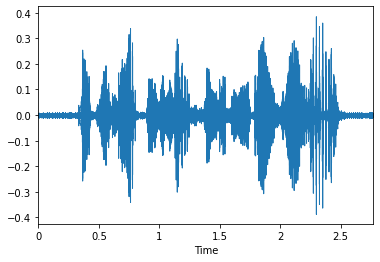

Reference text: IT WILL NOT BE SAFE FOR YOU TO STAY HERE NOW
ASR hypothesis: IT WILL NOT BE SAFE FOR YOU TO STAY HERE NOW
**************************************************


/usr/local/lib/python3.7/dist-packages/espnet/nets/ctc_prefix_score.py:325: RuntimeWarning: invalid value encountered in logaddexp
  r_prev[:, 0], r_prev[:, 1]


Input Speech: ESPNet_asr_egs/en/2.wav


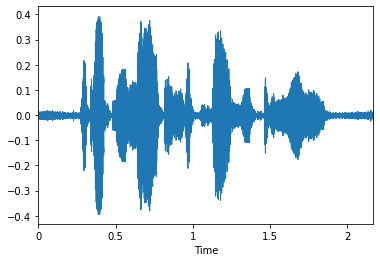

Reference text: IT WILL BE NO DISAPPOINTMENT TO ME
ASR hypothesis: IT WILL BE NO DISAPPOINTMENT TO ME
**************************************************
Input Speech: ESPNet_asr_egs/en/3.wav


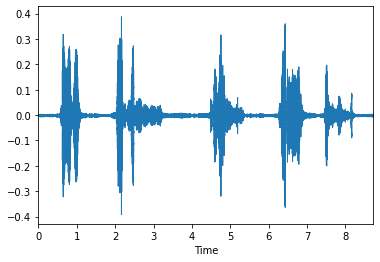

Reference text: HOWEVER THAT WAS OVER NOW THE TREE GONE THE STORY AT AN END
ASR hypothesis: HOWEVER THAT WAS OVER NOW THE TREE ON THE STORY HAD AN END
**************************************************
Input Speech: ESPNet_asr_egs/en/4.wav


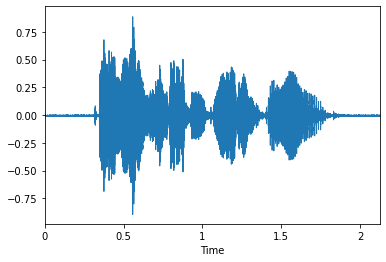

Reference text: ALL IS SAID WITHOUT A WORD
ASR hypothesis: ALL IS SAID WITHOUT A WORD
**************************************************
Input Speech: ESPNet_asr_egs/en/5.wav


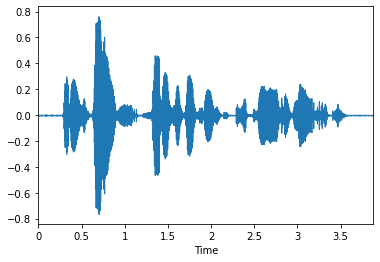

Reference text: IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
ASR hypothesis: IT IS THIS THAT IS OF INTEREST TO THEORY OF KNOWLEDGE
**************************************************


In [5]:
!git clone https://github.com/ftshijt/ESPNet_asr_egs.git

import pandas as pd
import soundfile
import librosa.display
from IPython.display import display, Audio
import matplotlib.pyplot as plt


egs = pd.read_csv("ESPNet_asr_egs/egs.csv")
for index, row in egs.iterrows():
  if row["lang"] == lang or lang == "multilingual":
    speech, rate = soundfile.read("ESPNet_asr_egs/" + row["path"])
    assert fs == int(row["sr"])
    nbests = speech2text(speech)

    text, *_ = nbests[0]
    print(f"Input Speech: ESPNet_asr_egs/{row['path']}")
    # let us listen to samples
    display(Audio(speech, rate=rate))
    librosa.display.waveplot(speech, sr=rate)
    plt.show()
    print(f"Reference text: {text_normalizer(row['text'])}")
    print(f"ASR hypothesis: {text_normalizer(text)}")
    print("*" * 50)

Speak to your microphone 15 sec...


<IPython.core.display.Javascript object>

Done!


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


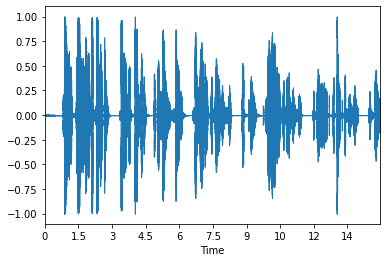

/usr/local/lib/python3.7/dist-packages/pysndfile/sndio.py:113: UserWarning: write_frames::warning::audio data has been clipped while writing to file audio_ds.wav.
  nf = sf.write_frames(data)


In [13]:
# from https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

audio = 'audio.wav'
second = 15
print(f"Speak to your microphone {second} sec...")
record(second, audio)
print("Done!")


import librosa
import librosa.display
speech, rate = librosa.load(audio, sr=16000)
librosa.display.waveplot(speech, sr=rate)

import matplotlib.pyplot as plt
plt.show()

import pysndfile
pysndfile.sndio.write('audio_ds.wav', speech, rate=rate, format='wav', enc='pcm16')

from IPython.display import display, Audio
display(Audio(speech, rate=rate))

In [14]:
nbests = speech2text(speech)
text, *_ = nbests[0]

print(f"ASR hypothesis: {text_normalizer(text)}")

/usr/local/lib/python3.7/dist-packages/espnet2/layers/stft.py:164: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  olens = (ilens - self.n_fft) // self.hop_length + 1


ASR hypothesis: THIS RACE IS A QUESTION HOW IS IT POSSIBLE TO COMBINE 5 HIGHORDER ADMISSIONS WITH 3 LOWORDER ADJUNCTS TO GENERATE A PROTOTYPE


In [15]:
# NOTE: pip shows imcompatible errors due to preinstalled libraries but you do not need to care
# It takes 1 minute
!pip install -q pyopenjtalk==0.1.5 parallel_wavegan==0.5.3

     |████████████████████████████████| 1.5 MB 33.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |████████████████████████████████| 125 kB 71.4 MB/s 


In [16]:
#@title Choose English model { run: "auto" }
lang = 'English'
tag = 'kan-bayashi/ljspeech_vits' #@param ["kan-bayashi/ljspeech_tacotron2", "kan-bayashi/ljspeech_fastspeech", "kan-bayashi/ljspeech_fastspeech2", "kan-bayashi/ljspeech_conformer_fastspeech2", "kan-bayashi/ljspeech_vits"] {type:"string"}
vocoder_tag = "none" #@param ["none", "parallel_wavegan/ljspeech_parallel_wavegan.v1", "parallel_wavegan/ljspeech_full_band_melgan.v2", "parallel_wavegan/ljspe

In [17]:
from espnet2.bin.tts_inference import Text2Speech
from espnet2.utils.types import str_or_none

text2speech = Text2Speech.from_pretrained(
    model_tag=str_or_none(tag),
    vocoder_tag=str_or_none(vocoder_tag),
    device="cuda",
    # Only for Tacotron 2 & Transformer
    threshold=0.5,
    # Only for Tacotron 2
    minlenratio=0.0,
    maxlenratio=10.0,
    use_att_constraint=False,
    backward_window=1,
    forward_window=3,
    # Only for FastSpeech & FastSpeech2 & VITS
    speed_control_alpha=1.0,
    # Only for VITS
    noise_scale=0.667,
    noise_scale_dur=0.8,
)

https://zenodo.org/record/5443814/files/tts_train_vits_raw_phn_tacotron_g2p_en_no_space_train.total_count.ave.zip?download=1: 100%|██████████| 356M/356M [00:27<00:00, 13.8MB/s]
/usr/local/lib/python3.7/dist-packages/espnet2/gan_tts/vits/monotonic_align/__init__.py:20: UserWarning: Cython version is not available. Fallback to 'EXPERIMETAL' numba version. If you want to use the cython version, please build it as follows: `cd espnet2/gan_tts/vits/monotonic_align; python setup.py build_ext --inplace`
  "Cython version is not available. Fallback to 'EXPERIMETAL' numba version. "


In [18]:
import time
import torch

# decide the input sentence by yourself
print(f"Input your favorite sentence in {lang}.")
x = input()

# synthesis
with torch.no_grad():
    start = time.time()
    wav = text2speech(x)["wav"]
rtf = (time.time() - start) / (len(wav) / text2speech.fs)
print(f"RTF = {rtf:5f}")

# let us listen to generated samples
from IPython.display import display, Audio
display(Audio(wav.view(-1).cpu().numpy(), rate=text2speech.fs))

Input your favorite sentence in English.
Good evening! how are you doing today?
RTF = 0.413658


In [19]:
# Download one utterance from real noisy speech of CHiME4
!gdown --id 1SmrN5NFSg6JuQSs2sfy3ehD8OIcqK6wS -O /content/M05_440C0213_PED_REAL.wav
import os

import soundfile
from IPython.display import display, Audio
mixwav_mc, sr = soundfile.read("/content/M05_440C0213_PED_REAL.wav")
# mixwav.shape: num_samples, num_channels
mixwav_sc = mixwav_mc[:,4]
display(Audio(mixwav_mc.T, rate=sr))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SmrN5NFSg6JuQSs2sfy3ehD8OIcqK6wS
To: /content/M05_440C0213_PED_REAL.wav
100% 932k/932k [00:00<00:00, 149MB/s]


In [20]:
!gdown --id 17DMWdw84wF3fz3t7ia1zssdzhkpVQGZm -O /content/chime_tasnet_singlechannel.zip
!unzip /content/chime_tasnet_singlechannel.zip -d /content/enh_model_sc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17DMWdw84wF3fz3t7ia1zssdzhkpVQGZm
To: /content/chime_tasnet_singlechannel.zip
100% 34.7M/34.7M [00:00<00:00, 51.0MB/s]
Archive:  /content/chime_tasnet_singlechannel.zip
 extracting: /content/enh_model_sc/meta.yaml  
 extracting: /content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/config.yaml  
 extracting: /content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/5epoch.pth  
 extracting: /content/enh_model_sc/exp/enh_stats_16k/train/feats_stats.npz  


In [21]:
# Load the model
# If you encounter error "No module named 'espnet2'", please re-run the 1st Cell. This might be a colab bug.
import sys
import soundfile
from espnet2.bin.enh_inference import SeparateSpeech


separate_speech = {}
# For models downloaded from GoogleDrive, you can use the following script:
enh_model_sc = SeparateSpeech(
  train_config="/content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/config.yaml",
  model_file="/content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/5epoch.pth",
  # for segment-wise process on long speech
  normalize_segment_scale=False,
  show_progressbar=True,
  ref_channel=4,
  normalize_output_wav=True,
  device="cuda:0",
)

In [22]:
# play the enhanced single-channel speech
wave = enh_model_sc(mixwav_sc[None, ...], sr)
print("Input real noisy speech", flush=True)
display(Audio(mixwav_sc, rate=sr))
print("Enhanced speech", flush=True)
display(Audio(wave[0].squeeze(), rate=sr))

Input real noisy speech


/usr/local/lib/python3.7/dist-packages/espnet2/enh/encoder/conv_encoder.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  flens = (ilens - self.kernel_size) // self.stride + 1


Enhanced speech
